In [71]:
import os
import numpy as np
import librosa
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from sklearn.model_selection import train_test_split
import soundfile as sf
from tqdm import tqdm
from tensorflow.keras import regularizers
import matplotlib.pyplot as plt

In [2]:
# Paths to your dataset folders
WAKEWORD_DIR = "C:/Users/Arbaz Khan/Desktop/1"
BACKGROUND_DIR = "C:/Users/Arbaz Khan/Desktop/0"
SAMPLE_RATE = 16000  # Adjust based on your dataset
MFCC_FEATURES = 13   # Number of MFCC features

In [38]:
def extract_mfcc(file_path, max_length=40):
    """Extract MFCC features from an audio file."""
    y, sr = librosa.load(file_path, sr=SAMPLE_RATE)
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=MFCC_FEATURES)
    # Pad or truncate to fixed length
    if mfcc.shape[1] < max_length:
        mfcc = np.pad(mfcc, ((0, 0), (0, max_length - mfcc.shape[1])), mode='constant')
    else:
        mfcc = mfcc[:, :max_length]
    return mfcc

In [39]:
def load_data(data_dir, label, max_files=10000):
    """Load dataset and extract MFCC features."""
    data, labels = [], []
    files = os.listdir(data_dir)[:max_files]  # Limit files for training
    for file in tqdm(files):
        file_path = os.path.join(data_dir, file)
        if file.endswith('.wav'):
            mfcc = extract_mfcc(file_path)
            data.append(mfcc)
            labels.append(label)
    return np.array(data), np.array(labels)

In [40]:
# Load wake word and background noise datasets
wake_data, wake_labels = load_data(WAKEWORD_DIR, 1)
noise_data, noise_labels = load_data(BACKGROUND_DIR, 0)

  4%|▍         | 443/10000 [00:19<06:03, 26.32it/s]c:\Users\Arbaz Khan\Desktop\LangChain\venv\Lib\site-packages\librosa\core\spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1408
  warnings.warn(
  9%|▉         | 908/10000 [00:33<06:37, 22.88it/s]c:\Users\Arbaz Khan\Desktop\LangChain\venv\Lib\site-packages\librosa\core\spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1088
  warnings.warn(
 12%|█▏        | 1240/10000 [00:48<05:28, 26.66it/s]c:\Users\Arbaz Khan\Desktop\LangChain\venv\Lib\site-packages\librosa\core\spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1920
  warnings.warn(
 13%|█▎        | 1333/10000 [00:52<06:14, 23.17it/s]c:\Users\Arbaz Khan\Desktop\LangChain\venv\Lib\site-packages\librosa\core\spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1344
  warnings.warn(
100%|██████████| 10000/10000 [06:07<00:00, 27.21it/s]


In [41]:
len(wake_data) ,len(wake_labels), len(noise_data), len(noise_labels)

(10000, 10000, 10000, 10000)

In [42]:
# Combine and shuffle data
X = np.concatenate((wake_data, noise_data), axis=0)
Y = np.concatenate((wake_labels, noise_labels), axis=0)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [43]:
# Reshape for CNN input (batch, height, width, channels)
X_train = X_train[..., np.newaxis]
X_test = X_test[..., np.newaxis]

In [50]:
model = models.Sequential([
    layers.Conv2D(32, (3, 3),
                  activation='relu',
                  padding='same',
                  kernel_regularizer=regularizers.l2(0.001),
                  input_shape=(MFCC_FEATURES, 40, 1),
                  name='conv_layer1'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2), name='max_pooling1'),
    layers.Dropout(0.1),  # Adding dropout after first conv block
    
    layers.Conv2D(64, (3, 3),
                  activation='relu',
                  padding='same',
                  kernel_regularizer=regularizers.l2(0.001),
                  name='conv_layer2'),
    layers.MaxPooling2D((2, 2), name='max_pooling2'),
    layers.Dropout(0.2),  # Adding dropout after second conv block
    
    layers.Flatten(),
    layers.Dropout(0.3),  # Increasing dropout rate for dense layers
    layers.Dense(128,
                 activation='relu',
                 kernel_regularizer=regularizers.l2(0.001),
                 name='hidden_layer1'),
    layers.Dropout(0.3),  # Adding dropout before final layer
    layers.Dense(1,
                 activation='sigmoid',
                 kernel_regularizer=regularizers.l2(0.001),
                 name='output')
])

model.summary()

c:\Users\Arbaz Khan\Desktop\LangChain\venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv_layer1 (Conv2D)            │ (None, 13, 40, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 13, 40, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1 (MaxPooling2D)     │ (None, 6, 20, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 6, 20, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_layer2 (Conv2D)            │ (None, 6, 20, 64)      │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2 (MaxPooling2D)     │ (None, 3, 10, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 3, 10, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 1920)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 1920)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_layer1 (Dense)           │ (None, 128)            │       245,888 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 264,961 (1.01 MB)

 Trainable params: 264,897 (1.01 MB)

 Non-trainable params: 64 (256.00 B)

In [51]:
model.compile(
    optimizer=optimizers.Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)

In [52]:
# Define callbacks for early stopping and model checkpointing
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True
    ),
    tf.keras.callbacks.ModelCheckpoint(
        filepath='wake_word_model_best.h5',
        monitor='val_loss',
        save_best_only=True
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=2,
        min_lr=0.00001
    )
]

In [53]:
batch_size = 16
epochs = 10

history = model.fit(
    X_train, Y_train,
    validation_data=(X_test, Y_test),
    batch_size=batch_size,
    epochs=epochs,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.9458 - loss: 0.3526 - precision_1: 0.9448 - recall_1: 0.9471

1000/1000 ━━━━━━━━━━━━━━━━━━━━ 70s 61ms/step - accuracy: 0.9459 - loss: 0.3525 - precision_1: 0.9448 - recall_1: 0.9472 - val_accuracy: 1.0000 - val_loss: 0.1194 - val_precision_1: 1.0000 - val_recall_1: 1.0000 - learning_rate: 0.0010
Epoch 2/10
 999/1000 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.9947 - loss: 0.1154 - precision_1: 0.9939 - recall_1: 0.9958

1000/1000 ━━━━━━━━━━━━━━━━━━━━ 75s 75ms/step - accuracy: 0.9947 - loss: 0.1154 - precision_1: 0.9939 - recall_1: 0.9958 - val_accuracy: 1.0000 - val_loss: 0.0705 - val_precision_1: 1.0000 - val_recall_1: 1.0000 - learning_rate: 0.0010
Epoch 3/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.9965 - loss: 0.0724 - precision_1: 0.9960 - recall_1: 0.9971

1000/1000 ━━━━━━━━━━━━━━━━━━━━ 72s 72ms/step - accuracy: 0.9965 - loss: 0.0724 - precision_1: 0.9960 - recall_1: 0.9971 - val_accuracy: 0.9990 - val_loss: 0.0597 - val_precision_1: 0.9980 - val_recall_1: 1.0000 - learning_rate: 0.0010
Epoch 4/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 61s 61ms/step - accuracy: 0.9951 - loss: 0.0702 - precision_1: 0.9946 - recall_1: 0.9954 - val_accuracy: 0.9962 - val_loss: 0.0609 - val_precision_1: 0.9926 - val_recall_1: 1.0000 - learning_rate: 0.0010
Epoch 5/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.9977 - loss: 0.0499 - precision_1: 0.9974 - recall_1: 0.9980

1000/1000 ━━━━━━━━━━━━━━━━━━━━ 73s 73ms/step - accuracy: 0.9977 - loss: 0.0499 - precision_1: 0.9974 - recall_1: 0.9980 - val_accuracy: 0.9985 - val_loss: 0.0412 - val_precision_1: 0.9970 - val_recall_1: 1.0000 - learning_rate: 0.0010
Epoch 6/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 0.9957 - loss: 0.0519 - precision_1: 0.9946 - recall_1: 0.9967

1000/1000 ━━━━━━━━━━━━━━━━━━━━ 88s 88ms/step - accuracy: 0.9957 - loss: 0.0519 - precision_1: 0.9946 - recall_1: 0.9967 - val_accuracy: 0.9998 - val_loss: 0.0393 - val_precision_1: 0.9995 - val_recall_1: 1.0000 - learning_rate: 0.0010
Epoch 7/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 69s 68ms/step - accuracy: 0.9975 - loss: 0.0423 - precision_1: 0.9969 - recall_1: 0.9982 - val_accuracy: 1.0000 - val_loss: 0.0433 - val_precision_1: 1.0000 - val_recall_1: 1.0000 - learning_rate: 0.0010
Epoch 8/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.9972 - loss: 0.0455 - precision_1: 0.9972 - recall_1: 0.9973

1000/1000 ━━━━━━━━━━━━━━━━━━━━ 72s 58ms/step - accuracy: 0.9972 - loss: 0.0455 - precision_1: 0.9972 - recall_1: 0.9973 - val_accuracy: 0.9998 - val_loss: 0.0365 - val_precision_1: 0.9995 - val_recall_1: 1.0000 - learning_rate: 0.0010
Epoch 9/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 67s 67ms/step - accuracy: 0.9967 - loss: 0.0428 - precision_1: 0.9960 - recall_1: 0.9974 - val_accuracy: 0.9980 - val_loss: 0.0427 - val_precision_1: 0.9961 - val_recall_1: 1.0000 - learning_rate: 0.0010
Epoch 10/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.9988 - loss: 0.0368 - precision_1: 0.9986 - recall_1: 0.9991

1000/1000 ━━━━━━━━━━━━━━━━━━━━ 69s 68ms/step - accuracy: 0.9988 - loss: 0.0368 - precision_1: 0.9986 - recall_1: 0.9991 - val_accuracy: 0.9998 - val_loss: 0.0295 - val_precision_1: 0.9995 - val_recall_1: 1.0000 - learning_rate: 0.0010


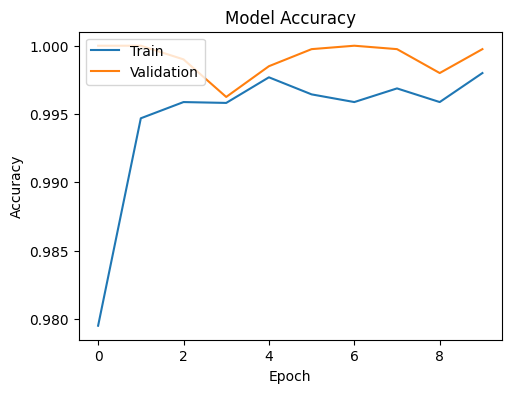

In [55]:
# Plot training history
plt.figure(figsize=(12, 4))

# Plot training & validation accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

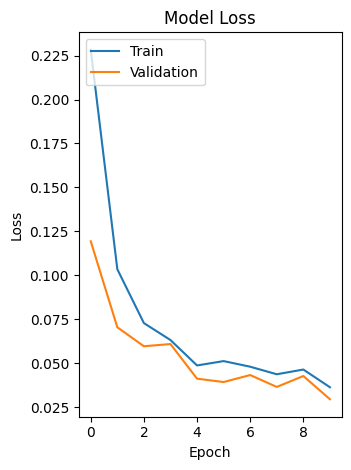

In [56]:
# Plot training & validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

In [57]:
test_results = model.evaluate(X_test, Y_test, verbose=1)
print(f"Test Loss: {test_results[0]:.4f}")
print(f"Test Accuracy: {test_results[1]:.4f}")
print(f"Test Precision: {test_results[2]:.4f}")
print(f"Test Recall: {test_results[3]:.4f}")

125/125 ━━━━━━━━━━━━━━━━━━━━ 7s 34ms/step - accuracy: 0.9990 - loss: 0.0299 - precision_1: 0.9980 - recall_1: 1.0000
Test Loss: 0.0295
Test Accuracy: 0.9998
Test Precision: 0.9995
Test Recall: 1.0000


In [58]:
# Save the final model
model.save('wake_word_model_final.h5')

print("Training complete. Model saved as wakeword_model.h5")

Training complete. Model saved as wakeword_model.h5


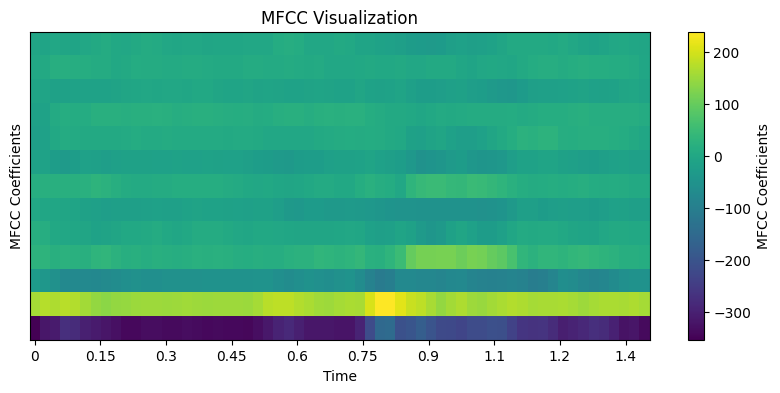

In [28]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np

# Path to an audio file
AUDIO_FILE = "0.wav"

# Load audio file with target sample rate
y, sr = librosa.load(AUDIO_FILE, sr=16000)  # Ensure it's 16kHz

# Extract MFCC features
mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)  # 13 MFCCs

# Plot MFCCs
plt.figure(figsize=(10, 4))
librosa.display.specshow(mfccs, x_axis="time", cmap="viridis")
plt.colorbar(label="MFCC Coefficients")
plt.title("MFCC Visualization")
plt.xlabel("Time")
plt.ylabel("MFCC Coefficients")
plt.show()

In [93]:
# Audio parameters (must match training settings)
SAMPLE_RATE = 16000
MFCC_FEATURES = 13
MAX_LENGTH = 40  # Ensure this matches what was used in training

# Function to extract MFCC features from an audio file
def extract_mfcc_from_file(file_path, sample_rate=SAMPLE_RATE, max_length=MAX_LENGTH):
    """Extract MFCC features from an audio file."""
    audio_data, sr = librosa.load(file_path, sr=sample_rate)  # Load and resample

    mfcc = librosa.feature.mfcc(y=audio_data, sr=sr, n_mfcc=MFCC_FEATURES)

    # Pad or truncate to fixed length
    if mfcc.shape[1] < max_length:
        mfcc = np.pad(mfcc, ((0, 0), (0, max_length - mfcc.shape[1])), mode='constant')
    else:
        mfcc = mfcc[:, :max_length]

    return mfcc

# Function to predict wake word from an audio file
def predict_wake_word(file_path):
    """Predict whether the given audio file contains the wake word."""
    mfcc = extract_mfcc_from_file(file_path)

    # Reshape for model input (batch, height, width, channels)
    mfcc = mfcc.reshape(1, MFCC_FEATURES, MAX_LENGTH, 1)

    # Predict using the model
    prediction = model.predict(mfcc, verbose=0)[0][0]

    # Print result
    if prediction > 0.50:
        print("\n🔊 Wake word detected! (Confidence: {:.2f}%)".format(prediction * 100))
        return True
    else:
        print("Wake word not detected. (Confidence: {:.2f}%)".format((1 - prediction) * 100))
        return False

# Example usage (Replace 'test_audio.wav' with your file)
file_path = "arbaz2.wav"  # Upload an audio file in Colab and provide the path
predict_wake_word(file_path)

Wake word not detected. (Confidence: 100.00%)


False

In [88]:
def plot_images2(images_arr, imageWidth, imageHeight):
    fig, axes = plt.subplots(2, 2, figsize=(10, 20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(np.reshape(img, (imageWidth, imageHeight)))
        ax.axis("off")
    plt.tight_layout()
    plt.show()

In [89]:
IMG_WIDTH=X_train[0].shape[0]
IMG_HEIGHT=X_train[0].shape[1]

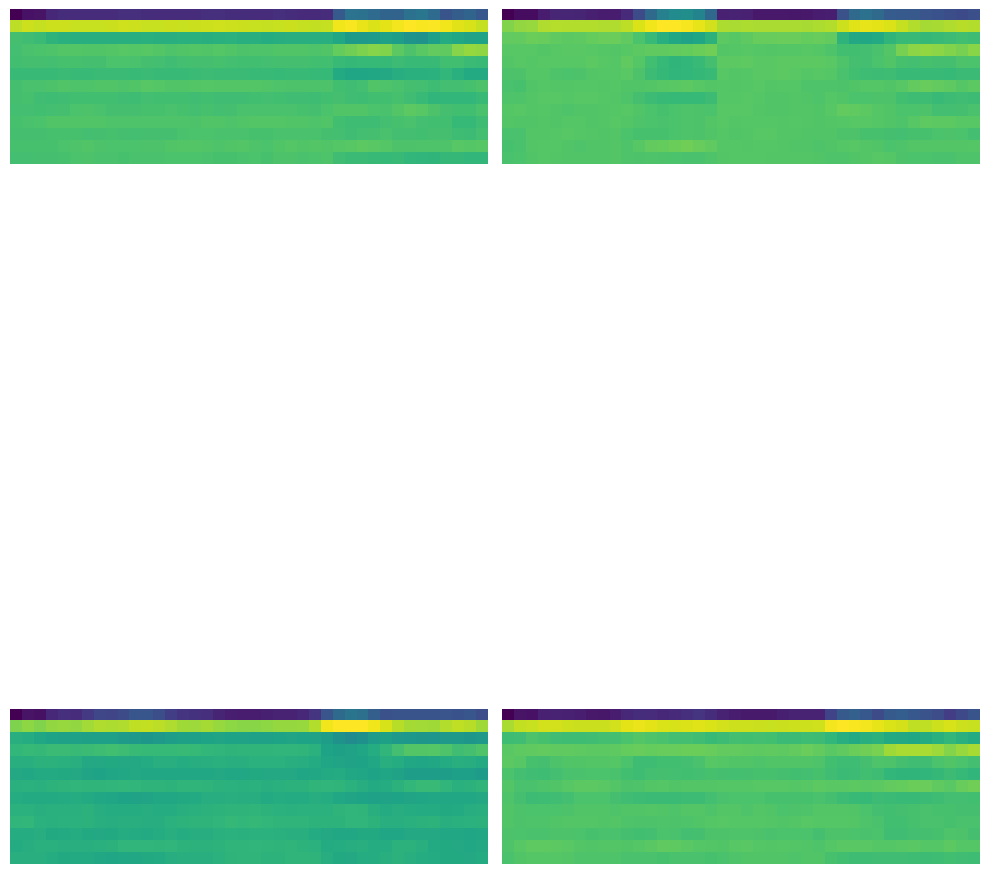

[1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 0 0 1 1 0]


In [95]:
plot_images2(X_train[:20], IMG_WIDTH, IMG_HEIGHT)
print(Y_train[:20])